# 2c. Evaluate models trained on patient-level snapshots

## Things to consider 

In the last notebook, I showed how to train models on patient snapshots using `patientflow`. Now, let's think about how to evaluate those models. 

When evaluating patient snapshots, we focus on:

* How well calibrated the predicted probabilities are.
* How well the probabilities discriminate between patients with and without the outcome.

We don't focus as much on typical classification metrics like Area under the ROC curve, accuracy or precision/recall. 

### Why don't we focus on typical classification metrics? 

The ultimate goal is to predict bed count distributions for groups of patients. Bed count distributions will be calculated in two steps

1. First, we predict the probability of the outcome we are interested in (admission or discharge) for each individual patient, as shown in previous notebooks.
2. Then, we use these probabilities in Bernoulli trials to get bed count distributions. The Bernouill trials step will be shown in later notebooks.

Because of this approach, the accuracy of the probability values matters more than correct classification. That is why we use log loss to optimise our classifiers. 

### About the data used in this notebook

I'm going to use real patient data from visits to the Emergency Department (ED) and Same Day Emergency Care (SDEC) unit at University College London Hospital (UCLH) to demonstrate the evaluation. For more information about the data, see [the data exploration notebook](2d_Explore_the_datasets_provided.ipynb).

The methods shown will work on any data in the same structure. 

You can request the datasets that are used here on [Zenodo](https://zenodo.org/records/14866057). Alternatively you can use the synthetic data that has been created from the distributions of real patient data. If you don't have the public data, change the argument in the cell below from `data_folder_name='data-public'` to `data_folder_name='data-synthetic'`.




In [2]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

## Loading real patient data

I load the data using a `load_data` function that will sort the data and return the tuple columns as tuples rather than strings or lists. If you run the cell below without the public dataset, you will need to change the `data_folder_name` or (better, since it will solve the problem for all notebooks) copy the synthetic data from `data-synthetic` to `data-public`. 

In [3]:
import pandas as pd
from patientflow.load import set_file_paths, load_data

# set project root
from patientflow.load import set_project_root
project_root = set_project_root()

# set file paths
data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
        project_root, 
        data_folder_name='data-public', # change this to data-synthetic if you don't have the public dataset
        verbose=False) 

# load the data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])

Inferred project root: /Users/zellaking/Repos/patientflow


In [4]:
ed_visits.age_group.value_counts()

age_group
25-34     23515
35-44     17700
18-24     15400
45-54     14860
55-64     14846
0-17      13586
75-115    12200
65-74     11228
Name: count, dtype: int64

Inspecting the data that has been loaded, we can see that it is similar in structure to the fake data that was generated on the fly in the previous notebooks. The dates have been pushed into the future, to minimise the likelihood of re-identifcation of patients.

The dates for training, validation and test sets that match this dataset are defined in the config file in the root directory of `patientflow`.

In [5]:
#  load config file
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set = params["start_training_set"]
print(f"Training set starts: {start_training_set}")

start_validation_set = params["start_validation_set"]
print(f"Validation set starts: {start_validation_set}")

start_test_set = params["start_test_set"] 
print(f"Test set starts: {start_test_set}")

end_test_set = params["end_test_set"]
print(f"Test set ends: {end_test_set}")


Training set starts: 2031-03-01
Validation set starts: 2031-09-01
Test set starts: 2031-10-01
Test set ends: 2032-01-01


## Train one model for each prediction time

First, we apply the temporal splits as shown in the previous notebook. 

In [6]:


from datetime import date   
from patientflow.prepare import create_temporal_splits

# create the temporal splits
train_visits, valid_visits, test_visits = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date", # states which column contains the date to use when making the splits 
    visit_col="visit_number", # states which column contains the visit number to use when making the splits 

)


Split sizes: [62071, 10415, 29134]


Next we specify the times of day at which are predictions are to be made. Here I'm deriving from the dataset. Note that there are many more snapshots in the later part of the day 12:00, 15:30 and 22:00

In [7]:
prediction_times = ed_visits.prediction_time.unique()
print("Models will be trained for the following prediction times. Note that each prediction time is a tuple of (hour, minute):")
print(prediction_times)

print("\nNumber of observations for each prediction time:")
print(ed_visits.prediction_time.value_counts())

Models will be trained for the following prediction times. Note that each prediction time is a tuple of (hour, minute):
[(22, 0) (15, 30) (6, 0) (12, 0) (9, 30)]

Number of observations for each prediction time:
prediction_time
(15, 30)    35310
(12, 0)     29942
(22, 0)     28457
(9, 30)     17642
(6, 0)      11984
Name: count, dtype: int64


Define ordinal mappings where appropriate. These include:

* `age_group` - Age on arrival at the ED, defined in groups
* `latest_obs_manchester_triage_acuity` - Manchester Triage Score (where blue is the lowest acuity and red the highest)
* `latest_obs_objective_pain_score` - ranging from nil to very severe 
* `latest_obs_level_of_consciousness` the ACVPU measure of consciousness, where A (aware) and U (unconscious) at are the extremes. 

In [8]:
ordinal_mappings = {
    "age_group": [
        "0-17",
        "18-24",
        "25-34",
        "35-44",
        "45-54",
        "55-64",
        "65-74",
        "75-115",
    ],
    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],
    "latest_obs_objective_pain_score": [
        "Nil",
        "Mild",
        "Moderate",
        "Severe_Very Severe",
    ],
    "latest_obs_level_of_consciousness": [
        "A", #alert
        "C", #confused
        "V", #voice - responds to voice stimulus
        "P", #pain - responds to pain stimulus
        "U" #unconscious - no response to pain or voice stimulus
    ]    }


In the real data, there are some columns that will be used for predicting admission to specialty, if admitted. I exclude them here.

In [9]:
exclude_from_training_data = [ 'snapshot_date', 'prediction_time','visit_number', 'consultation_sequence', 'specialty', 'final_sequence', ]

We loop through each prediction time, training a model. To start with, we will not balance the dataset. 

In [10]:
from patientflow.train.classifiers import train_classifier
from patientflow.load import get_model_key


trained_models = {} 

# Loop through each prediction time
for prediction_time in prediction_times:
    print(f"Training model for {prediction_time}")
    model = train_classifier(
        train_visits=train_visits,
        valid_visits=valid_visits,
        test_visits=test_visits,
        grid={"n_estimators": [20, 30, 40]},
        exclude_from_training_data=exclude_from_training_data,
        ordinal_mappings=ordinal_mappings,
        prediction_time=prediction_time,
        visit_col="visit_number",
        calibrate_probabilities=False,
        use_balanced_training=False,
    )
    
    model_name = 'admissions'
    model_key = get_model_key(model_name, prediction_time)
    
    trained_models[model_key] = model

Training model for (22, 0)
Training model for (15, 30)
Training model for (6, 0)
Training model for (12, 0)
Training model for (9, 30)


## Inspecting the base model

Below I show three different charts, all showing the calibration and discrimination of the models, in slightly different ways. 

### Discrimination plots

A discrimination plot shows the spread of predicted probabilities for positive and negative cases.

* X-axis (Predicted Probability): Represents the model's predicted probabilities from 0 to 1.
* Y-axis (Density): Shows the relative frequency of each probability value.

The plot displays two histograms:

* Blue line/area: Distribution of predicted probabilities for negative cases (patients who weren't admitted)
* Orange line/area: Distribution of predicted probabilities for positive cases (patients who were admitted)

Ideal separation between these distributions indicates a well-performing model:

* Negative cases (blue) should cluster toward lower probabilities (left side)
* Positive cases (orange) should cluster toward higher probabilities (right side)

The degree of overlap between distributions helps assess model discrimination ability. Less overlap suggests the model effectively distinguishes between positive and negative cases, while significant overlap indicates areas where the model struggles to differentiate between outcomes.

From the plot below, we see that the model is discriminating poorly, with a high degree of overlap, and very few positive cases at the higher end. 


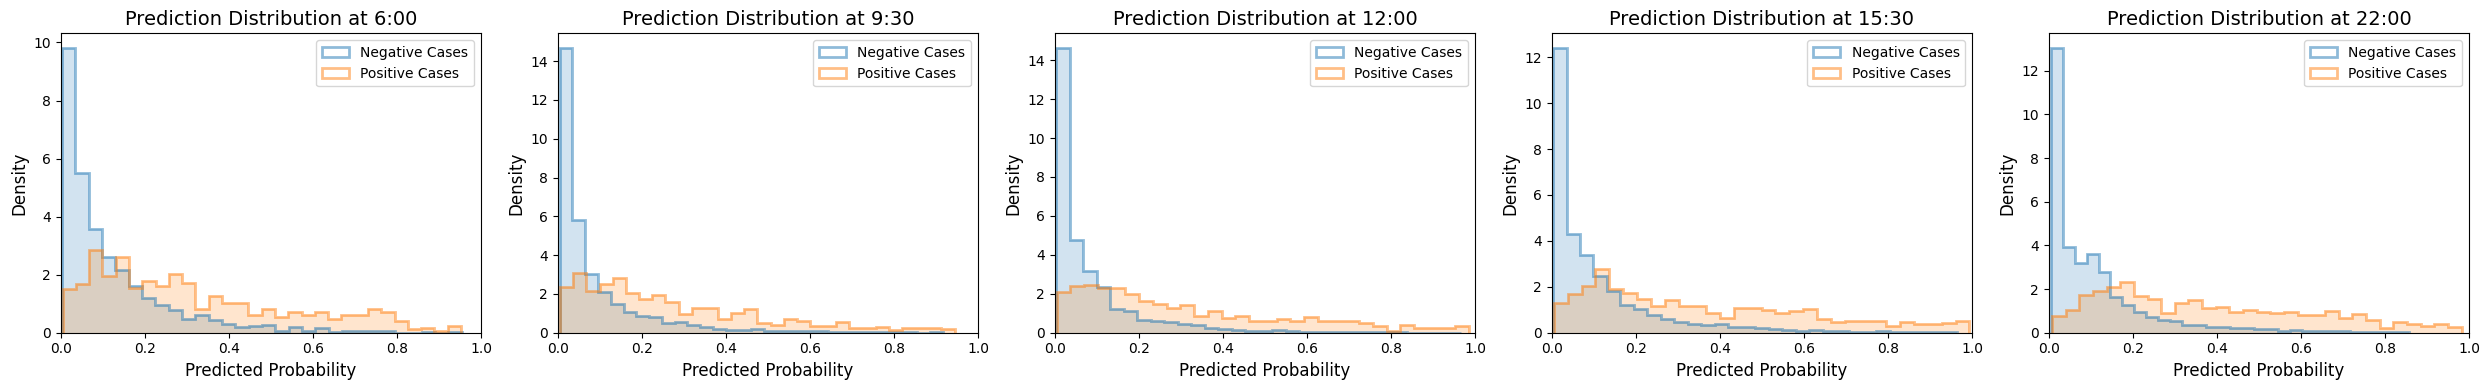

In [11]:
# without balanced training
from patientflow.viz.distribution_plots import plot_prediction_distributions
plot_prediction_distributions(
    trained_models=trained_models,  
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data
)


### Calibration plots

A calibration plot shows how well a model's predicted probabilities match actual outcomes.

- X-axis (Mean Predicted Probability): The model's predicted probabilities, ordered from 0 to 1, grouped into bins, either using the uniform or the quantile strategy (see below).
- Y-axis (Fraction of Positives): The observed proportion of admissions for visits in that group.

A perfectly calibrated model would align its points along the diagonal line, meaning a 70% predicted probability means the event happens 70% of the time.

Uniform vs Quantile Strategies:
- Uniform: Divides predictions into equal-width probability bins (e.g., 0.0-0.1, 0.1-0.2), so some bins may have few or many points.
- Quantile: Ensures each bin has the same number of predictions, regardless of how wide or narrow each bin's probability range is.

Below, we see reasonable calibration at the lower end, but deteriorating towards the higher end.

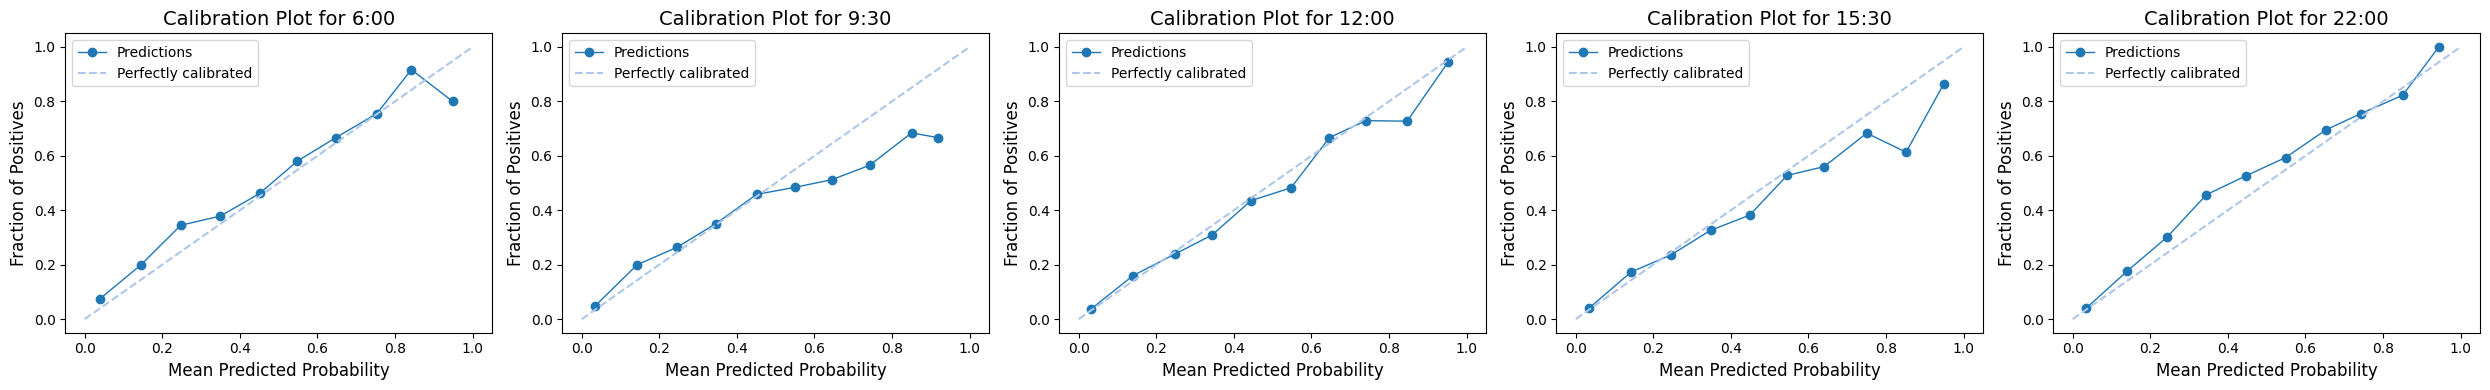

In [12]:
# without balanced training
from patientflow.viz.calibration_plot import plot_calibration

plot_calibration(
    trained_models=trained_models,  
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data,
    # strategy="quantile",  # optional
    # suptitle="Base model with imbalanced training data"  # optional
)

### MADCAP (Model Accuracy Diagnostic Calibration Plot)

A MADCAP (Model Accuracy Diagnostic Calibration Plot) visually compares the predicted probabilities from a model with the actual outcomes (e.g., admissions or events) in a dataset. This plot helps to assess how well the model's predicted probabilities align with the observed values.

The blue line represents the cumulative predicted outcomes, which are derived by summing the predicted probabilities as we move through the test set, ordered by increasing probability.
The orange line represents the cumulative observed outcomes, calculated based on the actual labels in the dataset, averaged over the same sorted order of predicted probabilities.

If the model is well calibrated, these two lines will closely follow each other. If the model discriminates well between positive and negative classes the curves will bow to the bottom left. 

Below, we see that some models under-predict the likelihood of admissions, as the blue line (predicted outcomes) falls below the orange line (actual outcomes). The models are assigning lower probabilities than they should, meaning that (later) we will under-predict the number of beds needed for these patients.

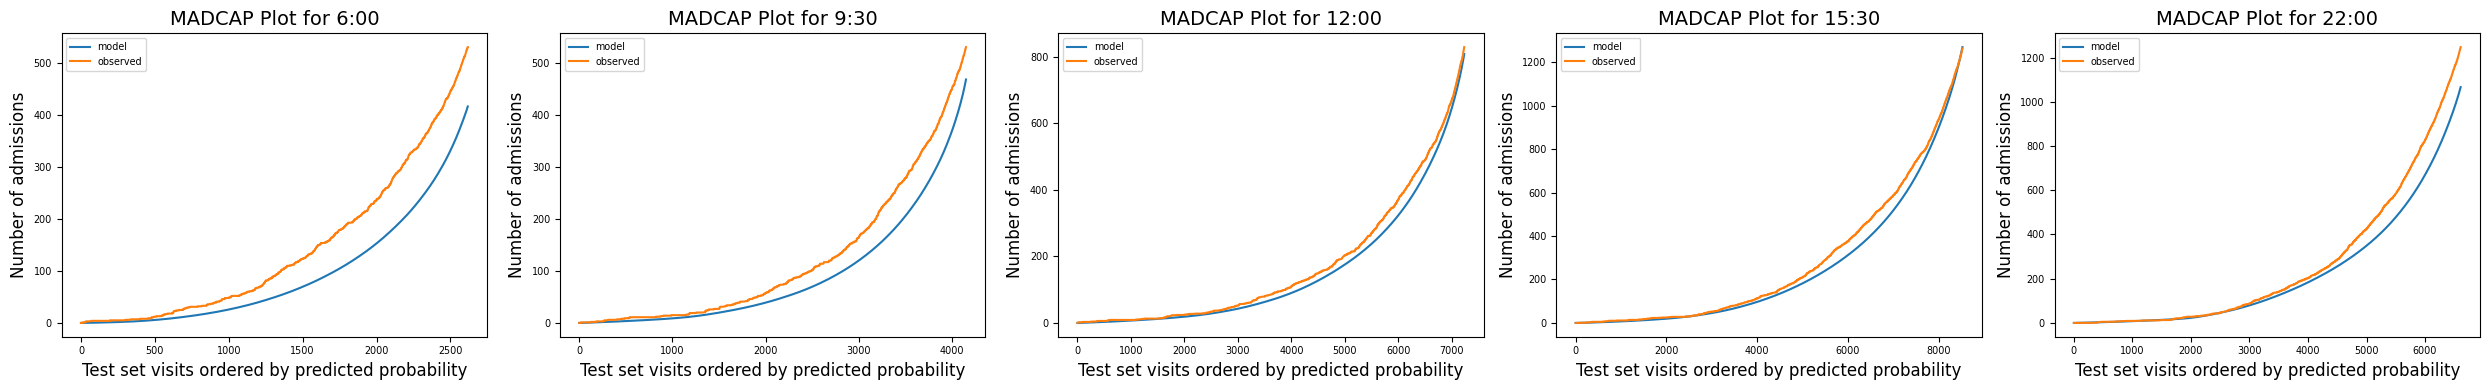

In [13]:
## without balanced training
from patientflow.viz.madcap_plot import generate_madcap_plots
generate_madcap_plots(
    trained_models=trained_models,
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data
)

## Inspecting a balanced model

These results are not bad, but it is common to attempt to handle unbalanced classes by under-sampling the majority class. 

The `train_classifier()` function will balance the training set, if `use_balanced_training` is set to True, as shown below. 

In [14]:
from patientflow.train.classifiers import train_classifier
from patientflow.load import get_model_key

trained_models = {}

# Loop through each prediction time
for prediction_time in prediction_times:
    print(f"Training model for {prediction_time}")
    model = train_classifier(
        train_visits=train_visits,
        valid_visits=valid_visits,
        test_visits=test_visits,
        grid={"n_estimators": [20, 30, 40]},
        exclude_from_training_data=exclude_from_training_data,
        ordinal_mappings=ordinal_mappings,
        prediction_time=prediction_time,
        visit_col="visit_number",
        calibrate_probabilities=False,
        calibration_method="sigmoid",
        use_balanced_training=True,
    )
    
    model_name = 'admissions'
    model_key = get_model_key(model_name, prediction_time)
    
    trained_models[model_key] = model


Training model for (22, 0)
Training model for (15, 30)
Training model for (6, 0)
Training model for (12, 0)
Training model for (9, 30)


From the plots below, we see improved discrimination. There are positive cases clustered at the right hand end of the distribution plot. However, this gain has come at the cost of much worse calibration when the models are applied to the whole test set, without undersampling the majority class, as shown in the calibation plot and MADCAP plots. 

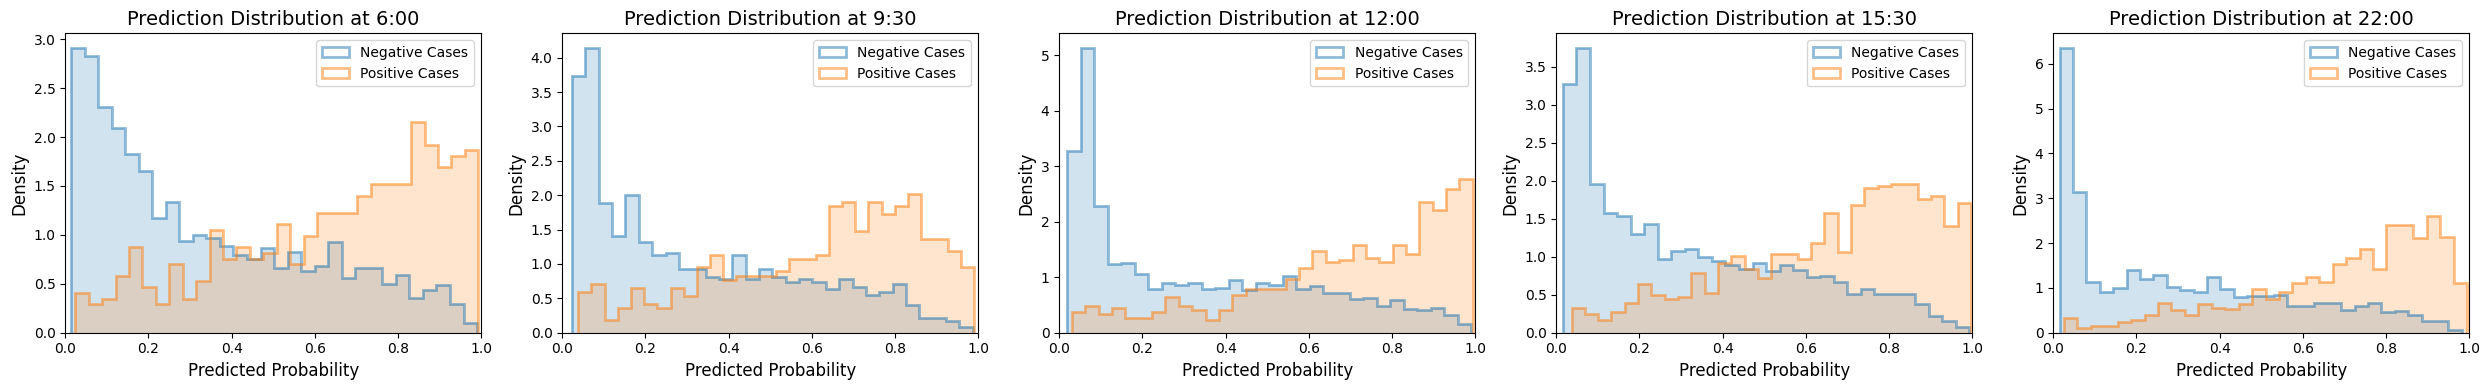

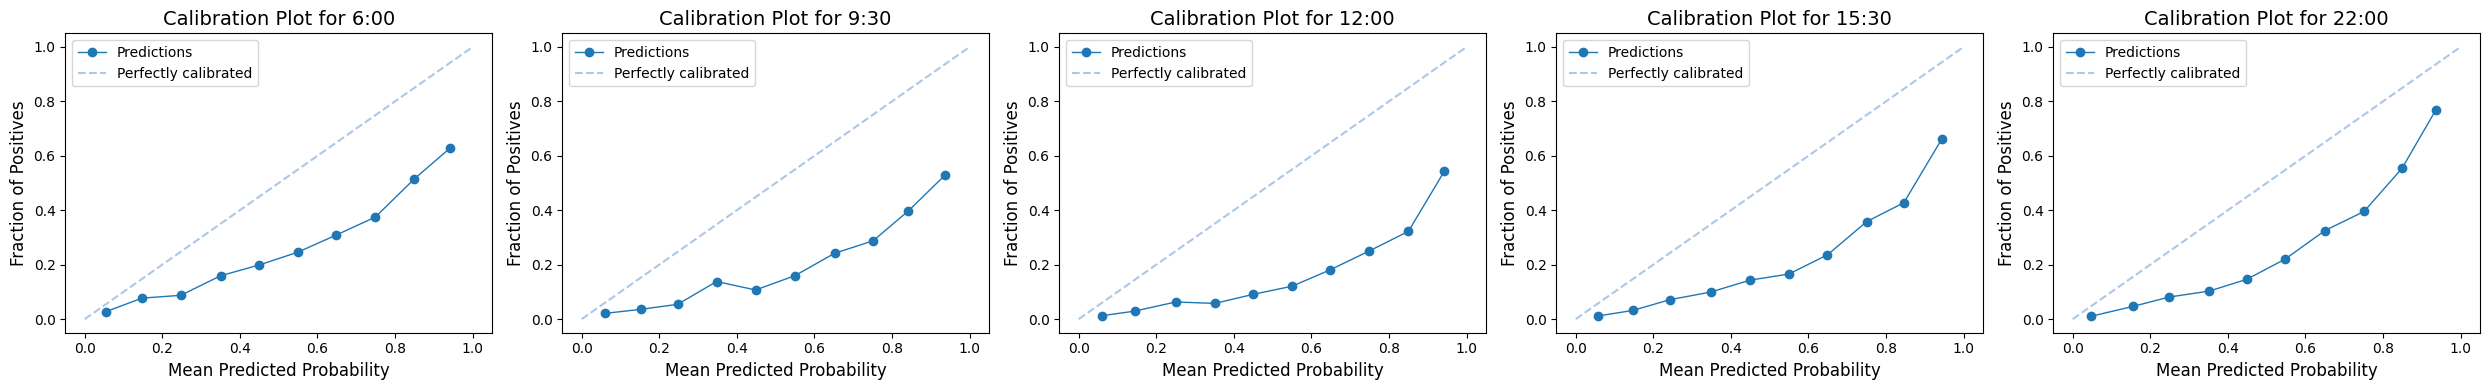

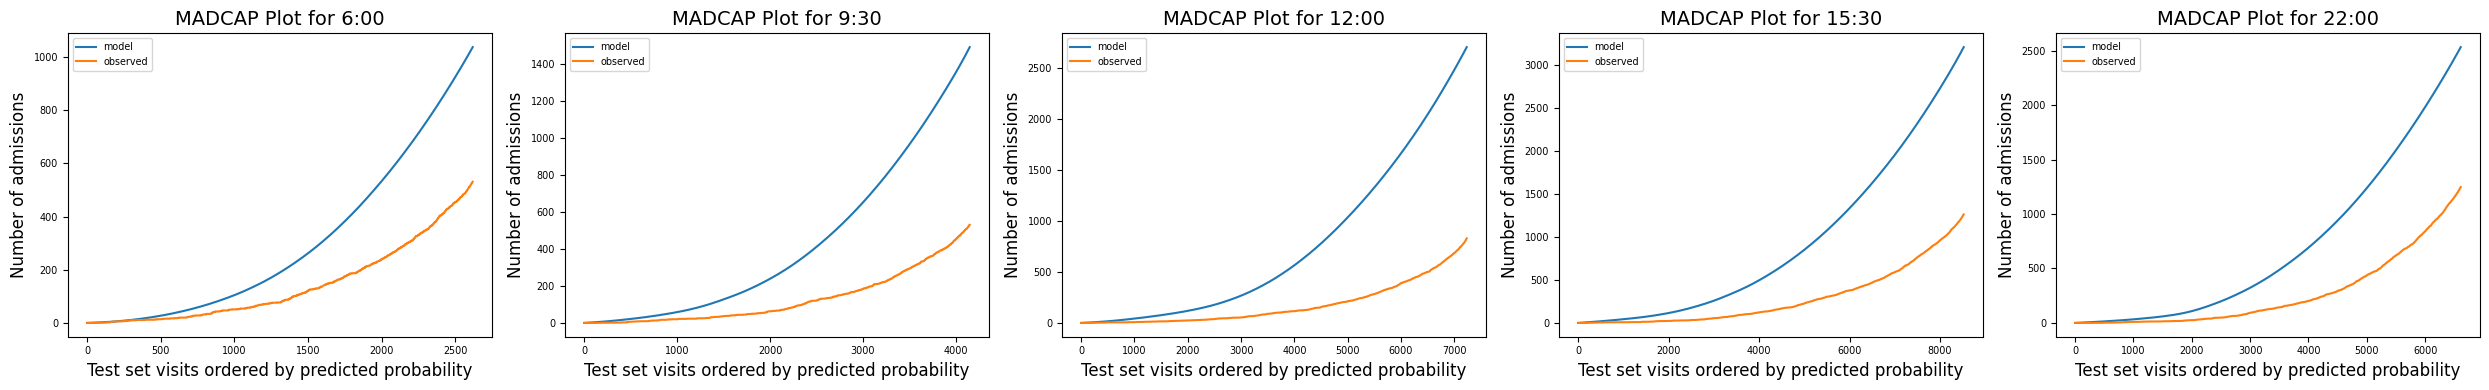

In [15]:
from patientflow.viz.distribution_plots import plot_prediction_distributions
from patientflow.viz.calibration_plot import plot_calibration
from patientflow.viz.madcap_plot import generate_madcap_plots

plot_prediction_distributions(
    trained_models=trained_models,  
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data
)
plot_calibration(
    trained_models=trained_models,  
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data,
    # strategy="quantile",  # optional
    # suptitle="Base model with balanced training data"  # optional
)

generate_madcap_plots(
    trained_models=trained_models,
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data
)

## Inspecting a balanced and calibrated model

A solution is to use the validation set to re-calibrate the probabilities generated by the model, so that they generate predictions that align with the true proportion of positive classes. From the plots below, we can see that calibration has been improved, but the calibration process has led to a truncation of the range of the predicted probabilities. 

Training model for (22, 0)
Training model for (15, 30)
Training model for (6, 0)
Training model for (12, 0)
Training model for (9, 30)


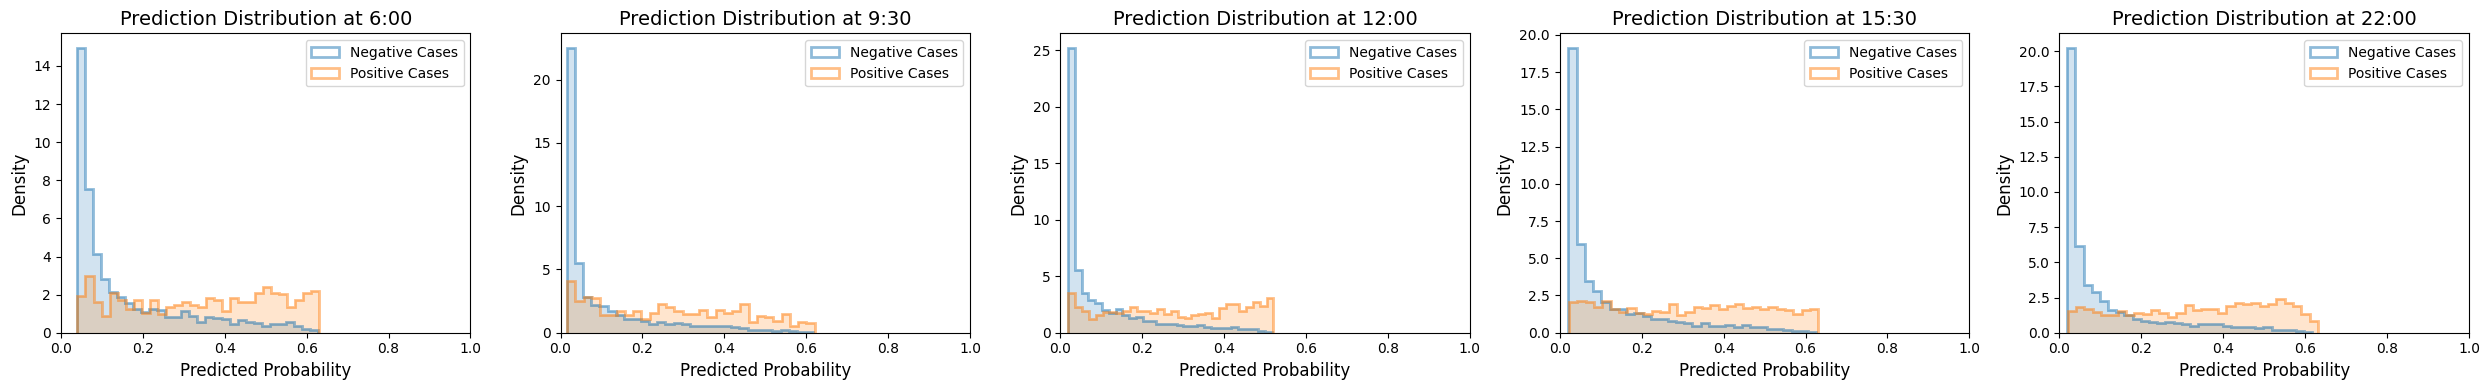

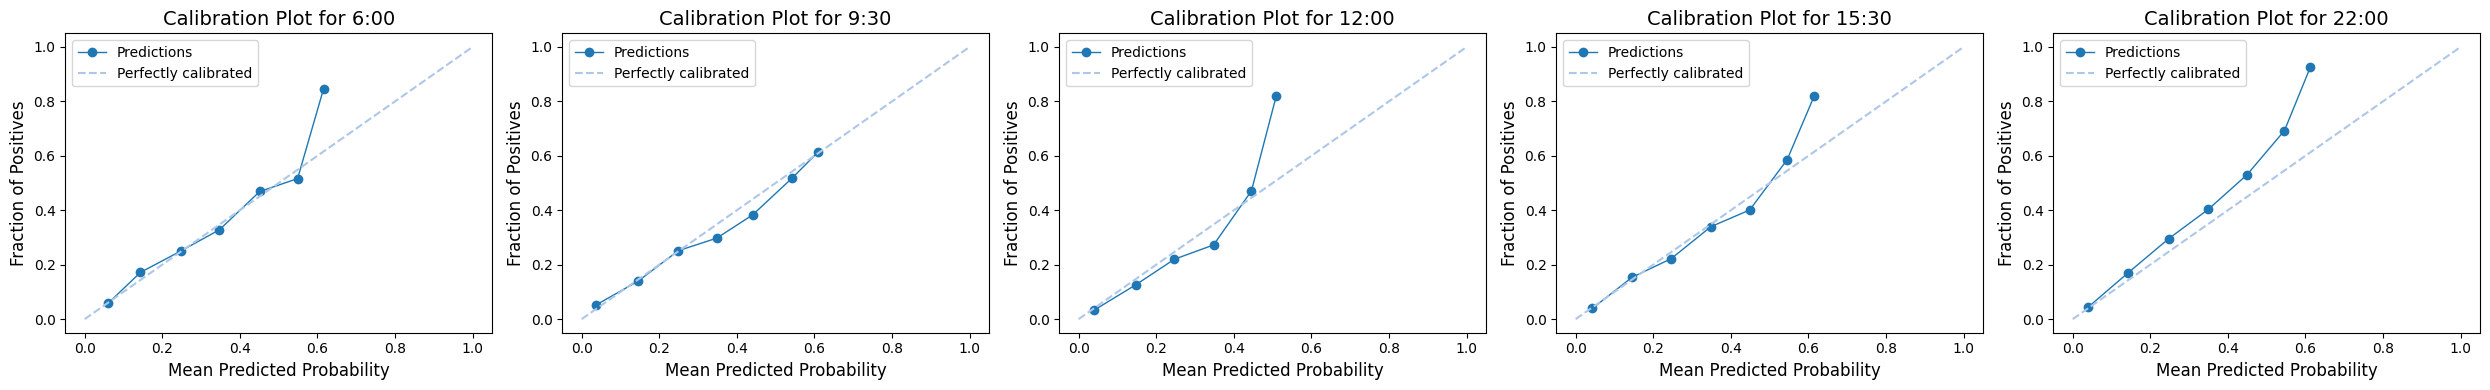

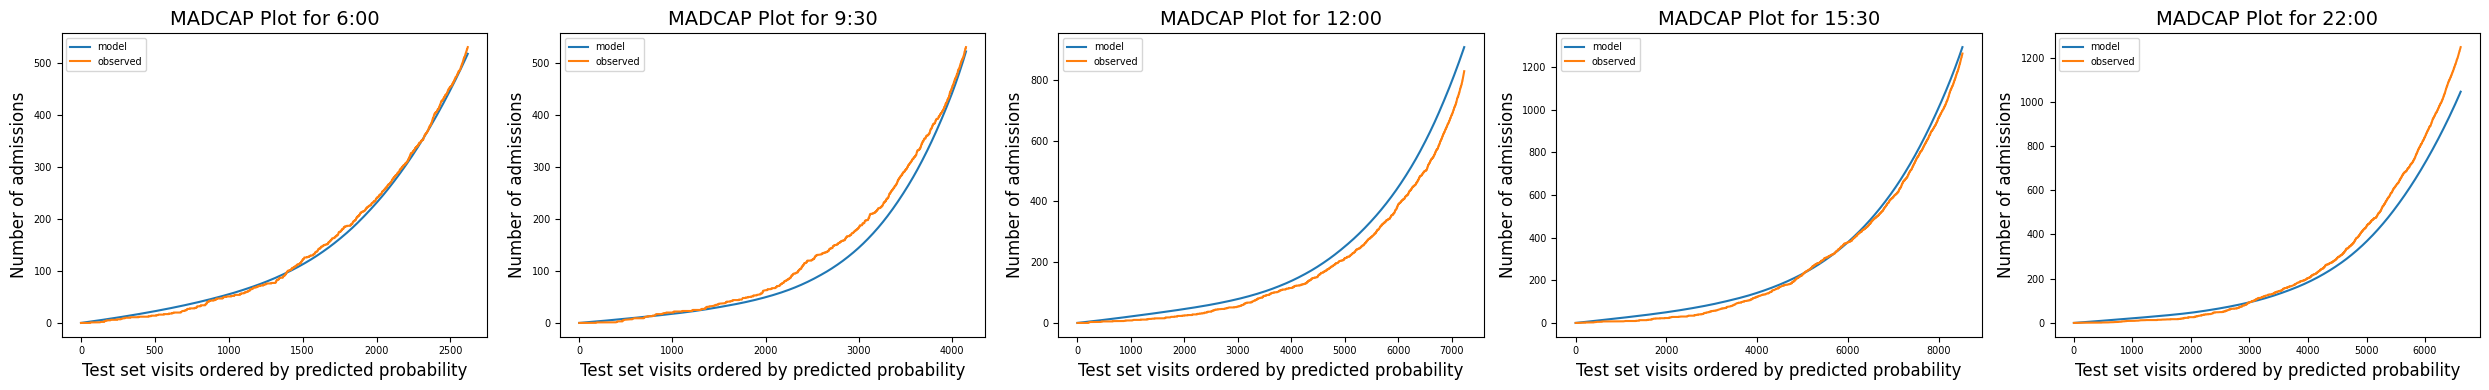

In [16]:
from patientflow.train.classifiers import train_classifier
from patientflow.viz.distribution_plots import plot_prediction_distributions
from patientflow.viz.calibration_plot import plot_calibration
from patientflow.viz.madcap_plot import generate_madcap_plots
from patientflow.load import get_model_key

trained_models = {}

# Loop through each prediction time
for prediction_time in prediction_times:
    print(f"Training model for {prediction_time}")
    model = train_classifier(
        train_visits=train_visits,
        valid_visits=valid_visits,
        test_visits=test_visits,
        grid={"n_estimators": [20, 30, 40]},
        exclude_from_training_data=exclude_from_training_data,
        ordinal_mappings=ordinal_mappings,
        prediction_time=prediction_time,
        visit_col="visit_number",
        calibrate_probabilities=True,
        calibration_method="sigmoid",
        use_balanced_training=True,
    )
    
    model_name = 'admissions'
    model_key = get_model_key(model_name, prediction_time)
    
    trained_models[model_key] = model

plot_prediction_distributions(
    trained_models=trained_models,  
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data
)
plot_calibration(
    trained_models=trained_models,  
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data,
    # strategy="quantile",  # optional
    # suptitle="Base model with balanced training data"  # optional
)

generate_madcap_plots(
    trained_models=trained_models,
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data
)

## MADCAP plots by age

It can be useful to look at sub-categories of patients, to understand whether models perform better for some groups. Here we show MADCAP plots by age group.

The performance is worse for children over all. There are fewer of them in the data, which can be seen by comparing the y axis limits; the y axis maximum is the total number of snapshots in the test that were in at the prediction time. In general, there are twice as many adults as over 65s (except at 22:00), and very few children. The models perform poorly for children, and best for adults under 65. They tend to under-predict for older people, especially at 22:00 and 06:00.  

Analysis like this helps understand the limitations of the modelling, and consider alternative approaches. For example, we might consider training a different model for older people, assuming enough data, or gathering more training data before deployment. 


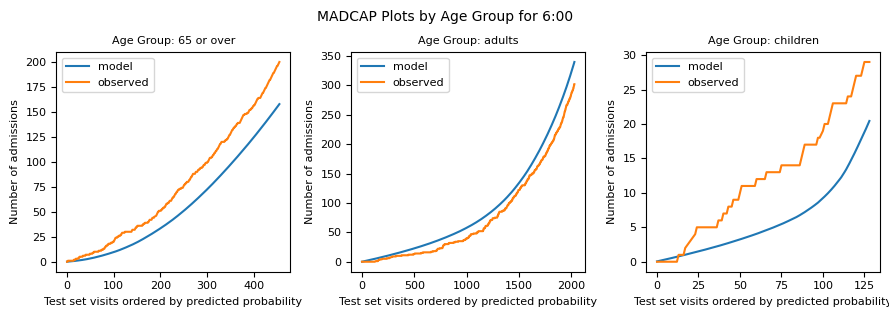

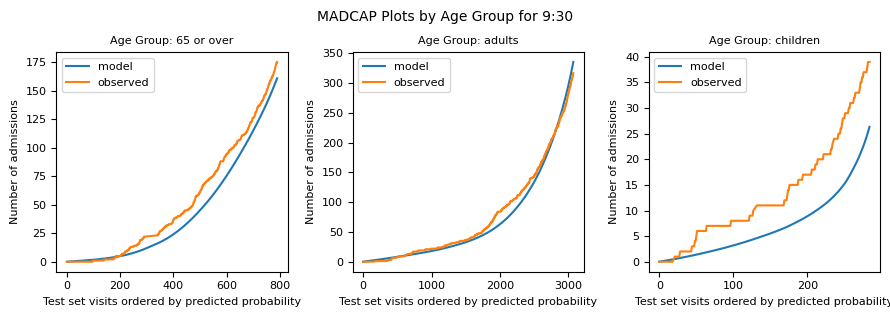

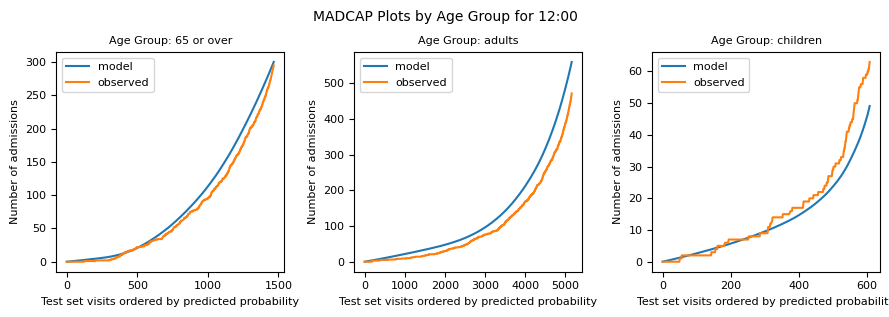

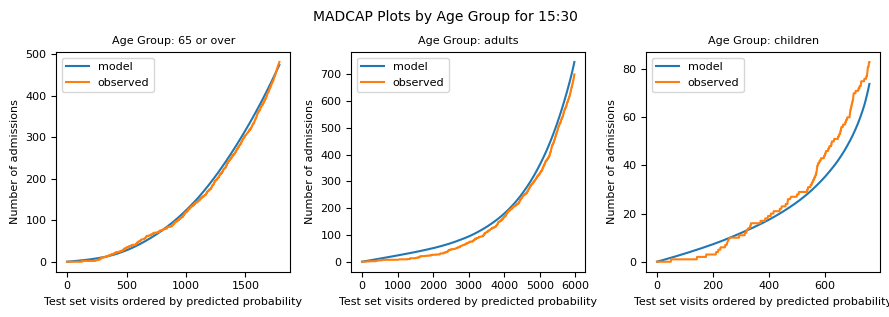

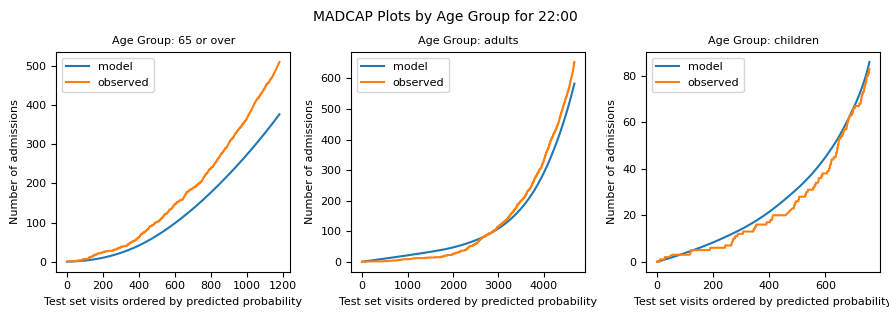

In [17]:
from patientflow.viz.madcap_plot import generate_madcap_plots_by_group
generate_madcap_plots_by_group(
    trained_models=trained_models,
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data,
    grouping_var="age_group",
    grouping_var_name="Age Group",
    plot_difference=False
)

## Feature importances and Shap plots

`patientflow` offers functions that generate Shap and feature importance plots for each prediction time. 



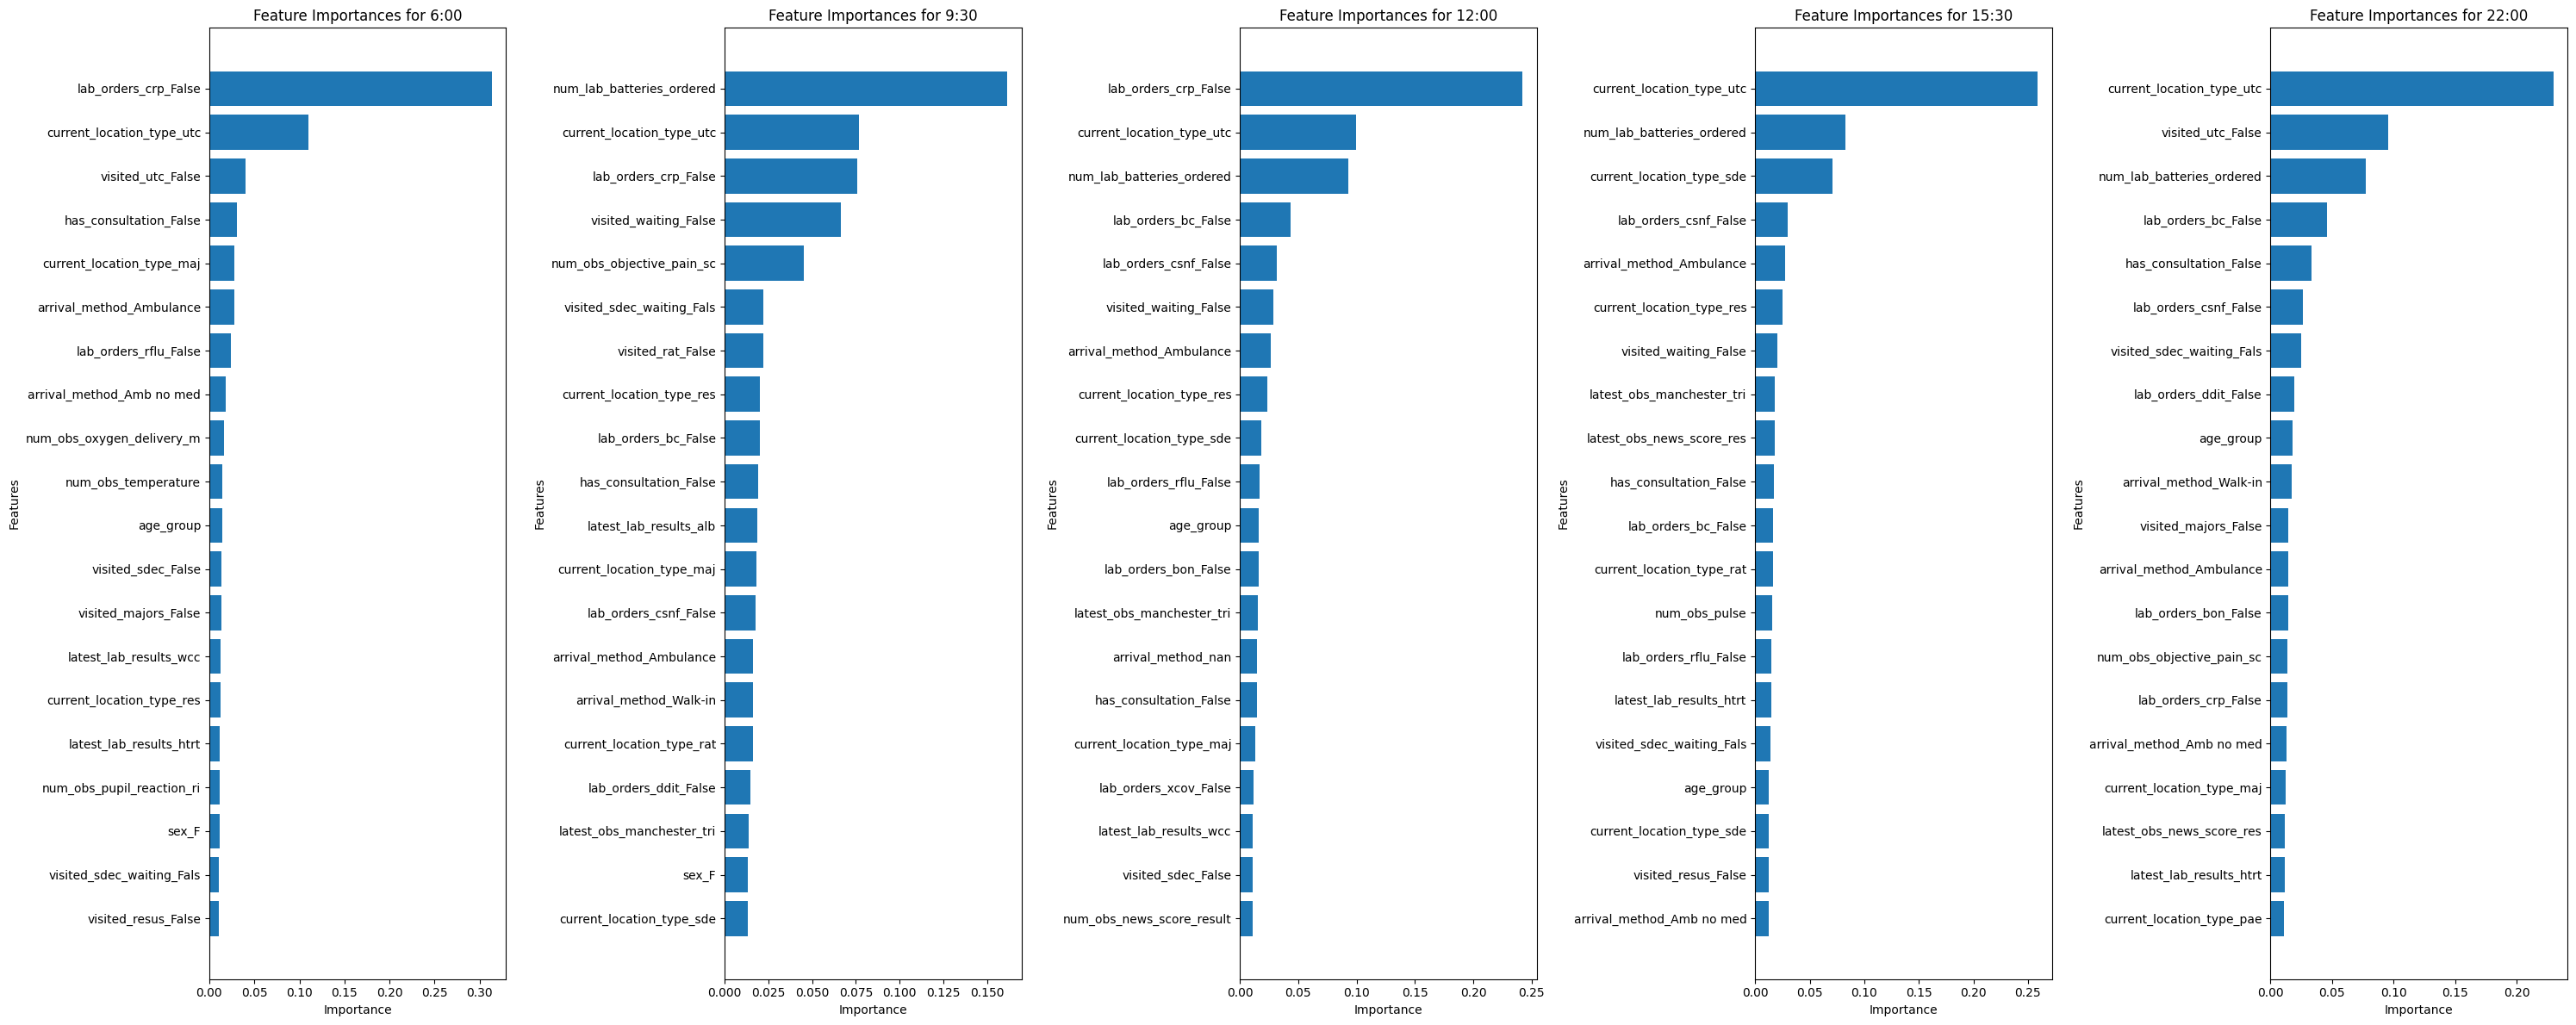

In [18]:
from patientflow.viz.feature_plot import plot_features

plot_features(
    trained_models)
    

Note that shap package is not loaded by default, due to dependency issues. You will need to pip install it here to generate the shap plots.

In [ ]:
!pip install shap

Predicted classification (not admitted, admitted):  [1666  952]


/Users/zellaking/Repos/patientflow/src/patientflow/viz/shap_plot.py:95: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


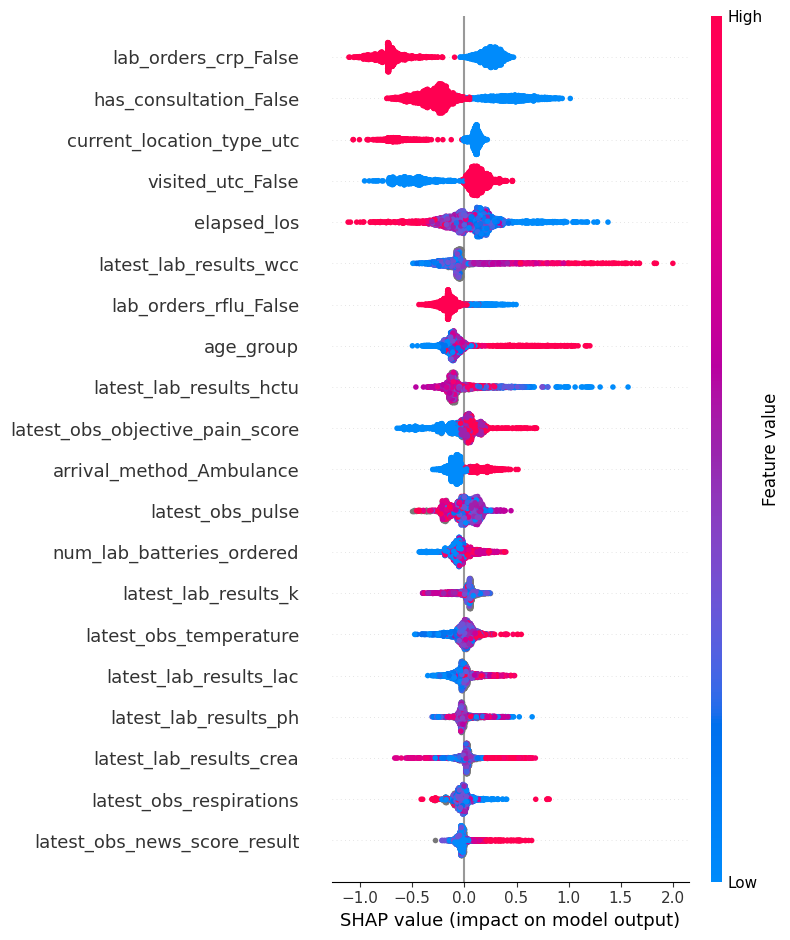

Predicted classification (not admitted, admitted):  [2823 1326]


/Users/zellaking/Repos/patientflow/src/patientflow/viz/shap_plot.py:95: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


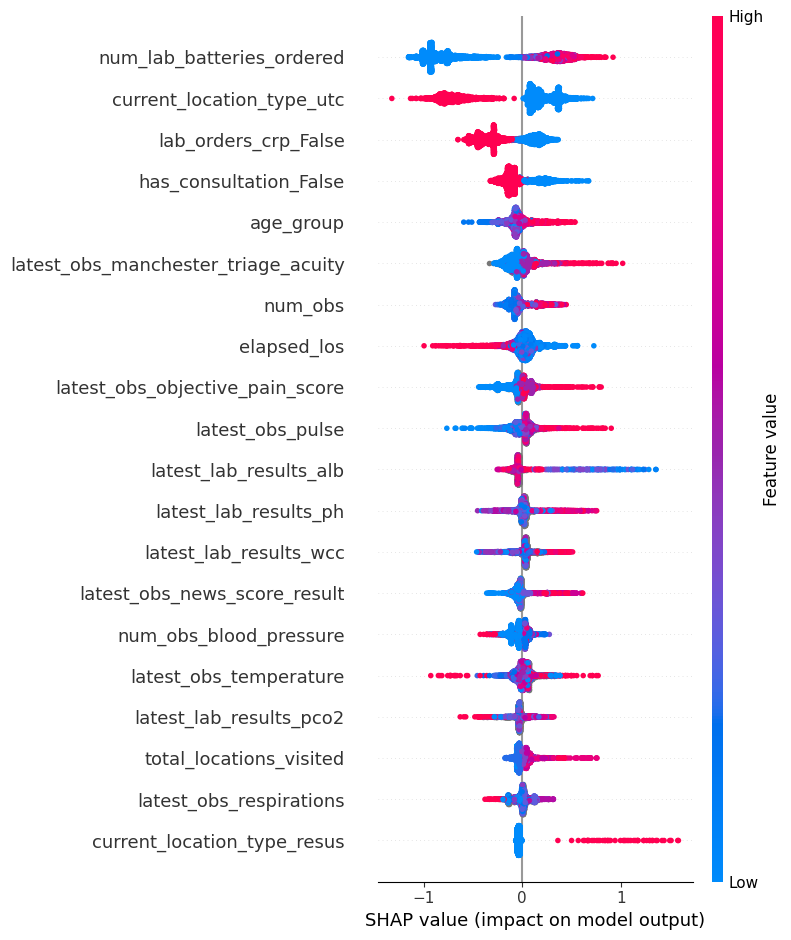

Predicted classification (not admitted, admitted):  [4687 2547]


/Users/zellaking/Repos/patientflow/src/patientflow/viz/shap_plot.py:95: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


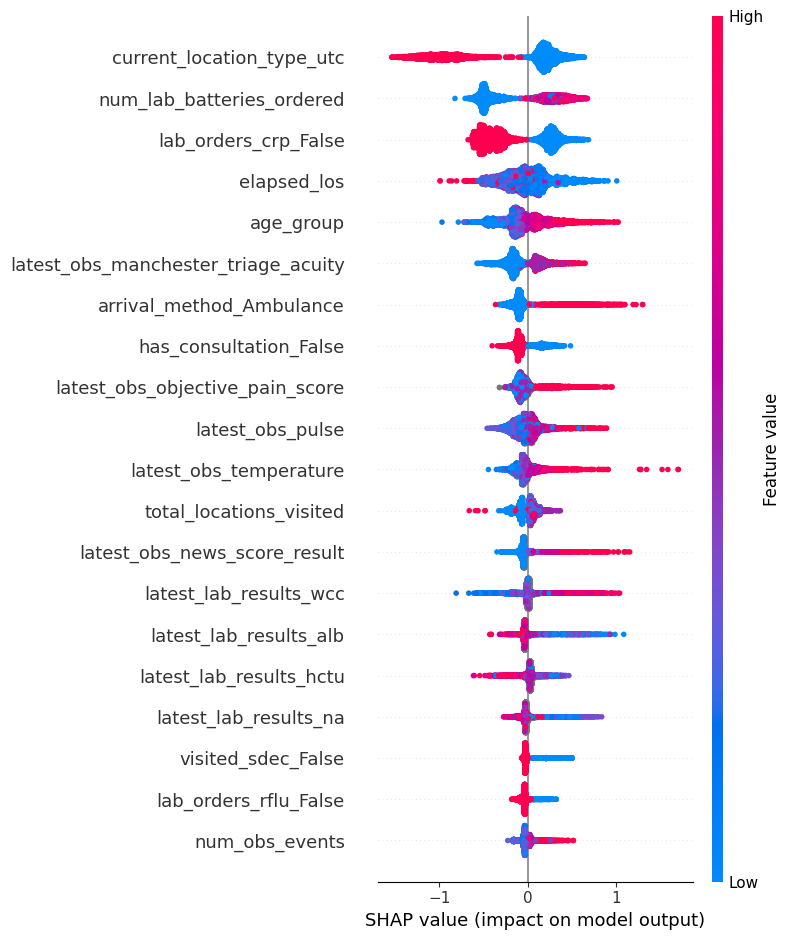

Predicted classification (not admitted, admitted):  [5609 2914]


/Users/zellaking/Repos/patientflow/src/patientflow/viz/shap_plot.py:95: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


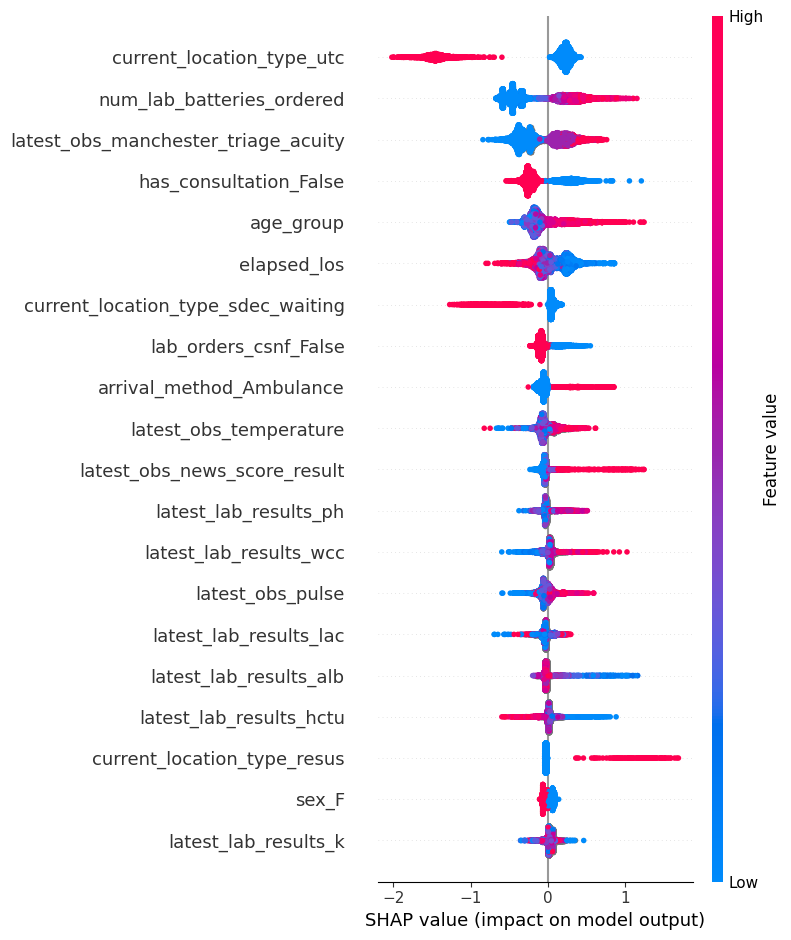

Predicted classification (not admitted, admitted):  [4256 2354]


/Users/zellaking/Repos/patientflow/src/patientflow/viz/shap_plot.py:95: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


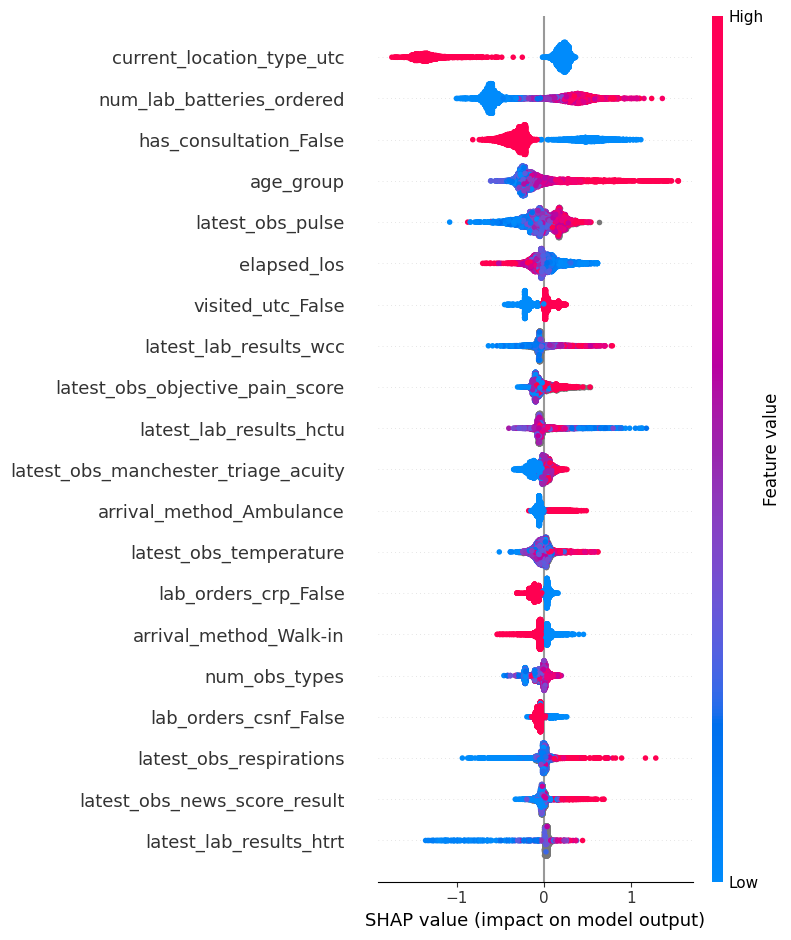

In [20]:
from patientflow.viz.shap_plot import plot_shap

plot_shap(
    trained_models, 
    test_visits,
    exclude_from_training_data)
    


## Conclusion

Here I have shown how visualations within `patientflow` can help you

* assess the discrimination and calibration of your models
* identify areas of weakness in your models by comparing predictions across different patient groups

I have also shown how using balanced training set, and re-calibrating using the validation set, can help to improve the discrimination of models where you start with imbalanced data. Imbalance is common in healthcare data. 

I demonstrated convenient functions to plot feature importances and Shap plots for the trained models. 

This notebook concludes the set covering patient snapshots. We have created predicted probabilities for each patient, based on what is known about them at the time of the snapshot. However, bed managers really want predictions for the whole cohort of patients at a time. This is where `patientflow` comes into its own. In the next notebook, I show how to create group snapshots. 